In [1]:
#Load the libraries
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.config import print_config
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    Resized,
    ScaleIntensityd,
    SpatialPadd,
    RandSpatialCropSamplesd,
    LambdaD
)

from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

print_config()


MONAI version: 1.4.dev2414
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b248f6a0dd29cb9c2a9545f980a88de16a6b753
MONAI __file__: /home/<username>/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about insta

### Setup the file input and output locations

In [2]:
logdir = os.path.normpath("./logs/FineTune/")

if os.path.exists(logdir) is False:
    os.mkdir(logdir)

In [11]:
#Load the pre-trained model
use_pretrained = True
pretrained_path = os.path.normpath("./logs/Train-Thresh-255-2000EP-16th.pth")


In [12]:
#Convert the train and validation images into a list with locations

train_dir = "./Data/FrenchSpeakerDataset/Segmentations/"
val_dir = "./Data/FrenchSpeakerDataset/Segmentations_Val/"

#train image file
#timage_filenames = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith("im")])
train_nrrd_files = sorted([os.path.join(train_dir, f) for f in os.listdir(
    train_dir) if f.endswith(".nrrd") and not f.endswith(".seg.nrrd")])
train_seg_nrrd_files = sorted([os.path.join(train_dir, f)
                        for f in os.listdir(train_dir) if f.endswith(".seg.nrrd")])
#validation image files
val_nrrd_files = sorted([os.path.join(val_dir, f) for f in os.listdir(
    val_dir) if f.endswith(".nrrd") and not f.endswith(".seg.nrrd")])
val_seg_nrrd_files = sorted([os.path.join(val_dir, f)
                             for f in os.listdir(val_dir) if f.endswith(".seg.nrrd")])

# Create a list of dictionaries containing the file paths
train_datalist = [{"image": img, "label": lbl}
                  for img, lbl in zip(train_nrrd_files, train_seg_nrrd_files)]
validation_datalist = [{"image": img, "label": lbl}
                for img, lbl in zip(val_nrrd_files, val_seg_nrrd_files)]

# Print the datalist to verify
print(validation_datalist[0])


{'image': './Data/FrenchSpeakerDataset/Segmentations_Val/P1_2.nrrd', 'label': './Data/FrenchSpeakerDataset/Segmentations_Val/P1_2.seg.nrrd'}


### Train and validation transforms

In [15]:
# Training Hyper-params
lr = 1e-4
max_iterations = 60000
eval_num = 100
experiment_name = "FrenchSpeaker-Thresh-255-60000St"

#Binarizing function


def binarize_label(label):
    return (label > 0).astype(label.dtype)

def threshold_image(image):
    return np.where(image < 20, 0, image)

# Transforms
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=0, maxv=255),
        LambdaD(keys="label", func=binarize_label),
        LambdaD(keys="image", func=threshold_image),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        SpatialPadd(keys=["image", "label"], spatial_size=(64, 64, 64)),
        RandSpatialCropSamplesd(keys=["image", "label"], roi_size=(
            64, 64, 64), random_size=False, num_samples=2),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

# Validation transforms
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=-1.0, maxv=1.0),
        LambdaD(keys="label", func=binarize_label),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)


### Dataloaders for train and validation

In [16]:

train_ds = CacheDataset(
    data=train_datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=2,
)
train_loader = DataLoader(train_ds, batch_size=1,
                          shuffle=True, num_workers=4, pin_memory=True)
val_ds = CacheDataset(data=validation_datalist, transform=val_transforms,
                      cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1,
                        shuffle=False, num_workers=4, pin_memory=True)


Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


<class 'numpy.ndarray'>
(64, 64)


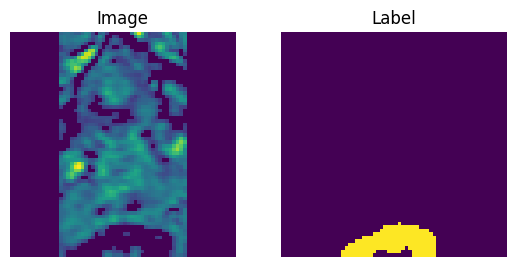

0.0


In [17]:
dataiter = iter(train_loader)
data = next(dataiter)
number = 15
label = data["label"].numpy().squeeze()[0, :, number, :]
image = data["image"].numpy().squeeze()[0, :, number, :]
print(type(label))
print(label.shape)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(label)
ax[1].set_title('Label')
ax[1].axis('off')

plt.show()
print(np.min(image))


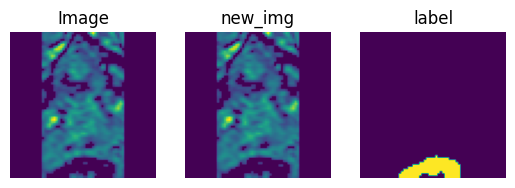

In [18]:
new_img = np.where(image < -0.8, -1.0, image)
np.max(new_img)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(new_img)
ax[1].set_title('new_img')
ax[1].axis('off')

ax[2].imshow(label)
ax[2].set_title('label')
ax[2].axis('off')

plt.show()


In [19]:
# just conforming the image sizes for the data inside the folder

for case_num in range(len(val_ds)):
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    img_shape = img.shape
    label_shape = label.shape
    print(f"image shape: {img_shape}, label shape: {label_shape}")

image shape: torch.Size([1, 123, 148, 36]), label shape: torch.Size([1, 123, 148, 36])


### Network

In [20]:
device = torch.device("cpu") # current GPU cannot handle this

model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(64, 64, 64),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="conv",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
)

# Load ViT backbone weights into UNETR
if use_pretrained is True:
    print("Loading Weights from the Path {}".format(pretrained_path))
    vit_dict = torch.load(pretrained_path)
    vit_weights = vit_dict["state_dict"]
    model_dict = model.vit.state_dict()

    vit_weights = {k: v for k, v in vit_weights.items() if k in model_dict}
    model_dict.update(vit_weights)
    model.vit.load_state_dict(model_dict)
    del model_dict, vit_weights, vit_dict
    print("Pretrained Weights Succesfully Loaded !")

elif use_pretrained is False:
    print("No weights were loaded, all weights being used are randomly initialized!")

model.to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True,
                         reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []


Loading Weights from the Path logs/Train-Thresh-255-2000EP-16th.pth
Pretrained Weights Succesfully Loaded !


### Train and validation 

In [21]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = []

    with torch.no_grad():
        for _step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (
                batch["image"], batch["label"])
            val_outputs = sliding_window_inference(
                val_inputs, (64, 64, 64), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(
                val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor)
                                  for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice))

        dice_metric.reset()

    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"], batch["label"])
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))

        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)

            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val))
                torch.save(model.state_dict(),
                           os.path.join(logdir, experiment_name + ".pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )

            plt.figure(1, (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Iteration Average Loss")
            x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("Iteration")
            plt.plot(x, y)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [eval_num * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("Iteration")
            plt.plot(x, y)
            plt.grid()
            plt.savefig(os.path.join(
                logdir, experiment_name + ".png"))
            plt.clf()
            plt.close(1)

        global_step += 1
    return global_step, dice_val_best, global_step_best


while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(
    os.path.join(logdir, experiment_name + ".pth")))

print(
    f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")


Validate (100 / 10 Steps) (dice=0.49662): 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


Model Was Saved ! Current Best Avg. Dice: 0.49661991000175476 Current Avg. Dice: 0.49661991000175476


Training (100 / 60000 Steps) (loss=0.85314):  10%|█         | 1/10 [00:10<01:38, 10.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.49661991000175476 Current Avg. Dice: 0.49661991000175476


Validate (200 / 10 Steps) (dice=0.49680): 100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


Model Was Saved ! Current Best Avg. Dice: 0.4967992603778839 Current Avg. Dice: 0.4967992603778839
Model Was Saved ! Current Best Avg. Dice: 0.4967992603778839 Current Avg. Dice: 0.4967992603778839


Validate (300 / 10 Steps) (dice=0.48300): 100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.4967992603778839 Current Avg. Dice: 0.4830023944377899


Training (311 / 60000 Steps) (loss=0.72891):  20%|██        | 2/10 [00:07<00:30,  3.75s/it]

In [1]:
print('hello')

hello
